In [ ]:
# reference: https://github.com/pytorch/vision/tree/main/references/segmentation

# prepare the run dir with right folder structure
!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/coco_utils.py ./
!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/transforms.py ./
!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/presets.py ./
!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/deeplab_utils.py ./
!ln -s /content/drive/MyDrive/DeeplabV3-seg-train/v2_extras.py ./

!ln -s /content/drive/MyDrive/Colab\ Notebooks/Mobile-Unet/utils ./

!ln -s /content/drive/MyDrive/OkraInsight/training_data ./

In [7]:
import argparse
import logging
import sys
import wandb
import glob
import cv2
import pickle

import datetime
import os
import time
import warnings

import presets
import torch
import torch.utils.data
import torchvision
import deeplab_utils
import random

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

from pathlib import Path
from torch import optim
from tqdm import tqdm
from coco_utils import get_coco

from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import functional as TF, InterpolationMode
from torch.utils.data import DataLoader, random_split

from utils.data_loading import BasicDataset, OkraDataset
from utils.dice_score import dice_loss

In [17]:
def get_okra(root, image_set, transforms, use_v2=False):
  print(root)
  #img_folder = os.path.join(root, '/images/class_okraSurface')
  #mask_folder = os.path.join(root, '/masks')
  img_folder = './training_data/okra_images/class_okra_surface'
  mask_folder ='./training_data/okra_segmentation_target_masks'
  return OkraDataset(img_folder, mask_folder, 0.1)

def get_dataset(args, is_train):
    def sbd(*args, **kwargs):
        kwargs.pop("use_v2")
        return torchvision.datasets.SBDataset(*args, mode="segmentation", **kwargs)

    def voc(*args, **kwargs):
        kwargs.pop("use_v2")
        return torchvision.datasets.VOCSegmentation(*args, **kwargs)

    paths = {
        "voc": (args.data_path, voc, 21),
        "voc_aug": (args.data_path, sbd, 21),
        "coco": (args.data_path, get_coco, 21),
        "okra":(args.data_path, get_okra, 1),
    }
    p, ds_fn, num_classes = paths[args.dataset]

    image_set = "train" if is_train else "val"
    ds = ds_fn(p, image_set=image_set, transforms=get_transform(is_train, args), use_v2=args.use_v2)

    # 2. Split into train / validation partitions
    val_percent = 0.1
    n_val = int(len(ds) * val_percent)
    n_train = len(ds) - n_val
    train_set, val_set = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(0))
    # print("n_val = ", n_val, ", n_train = ", n_train)
    if is_train:
      return train_set, num_classes
    else:
      return val_set, num_classes


def get_transform(is_train, args):
    if is_train:
        return presets.SegmentationPresetTrain(base_size=520, crop_size=480, backend=args.backend, use_v2=args.use_v2)
    elif args.weights and args.test_only:
        weights = torchvision.models.get_weight(args.weights)
        trans = weights.transforms()

        def preprocessing(img, target):
            img = trans(img)
            size = F.get_dimensions(img)[1:]
            target = F.resize(target, size, interpolation=InterpolationMode.NEAREST)
            return img, F.pil_to_tensor(target)

        return preprocessing
    else:
        return presets.SegmentationPresetEval(base_size=520, backend=args.backend, use_v2=args.use_v2)


def criterion(inputs, target):
    losses = {}
    #loss_fn=nn.functional.cross_entropy()
    #loss_fn = nn.MSELoss()
    loss_fn = nn.BCEWithLogitsLoss()
    for name, x in inputs.items():
      losses[name] = loss_fn(x.squeeze(1), target.float())
      losses[name] += dice_loss(F.sigmoid(x.squeeze(1)), target.float(), multiclass=False)
    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]


def evaluate(model, data_loader, device, num_classes):
    model.eval()
    confmat = deeplab_utils.ConfusionMatrix(num_classes)
    metric_logger = deeplab_utils.MetricLogger(delimiter="  ")
    header = "Test:"
    num_processed_samples = 0
    with torch.inference_mode():
        for image_target in metric_logger.log_every(data_loader, 100, header):
            image, target = image_target['image'].to(device), image_target['mask'].to(device)
            output = model(image)
            output = output["out"]

            confmat.update(target.flatten(), output.argmax(1).flatten())
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            num_processed_samples += image.shape[0]

        confmat.reduce_from_all_processes()

    num_processed_samples = deeplab_utils.reduce_across_processes(num_processed_samples)
    if (
        hasattr(data_loader.dataset, "__len__")
        and len(data_loader.dataset) != num_processed_samples
        and torch.distributed.get_rank() == 0
    ):
        # See FIXME above
        warnings.warn(
            f"It looks like the dataset has {len(data_loader.dataset)} samples, but {num_processed_samples} "
            "samples were used for the validation, which might bias the results. "
            "Try adjusting the batch size and / or the world size. "
            "Setting the world size to 1 is always a safe bet."
        )

    return confmat

def train_one_epoch(experiment, model, batch_size, global_step, criterion, optimizer, data_loader, lr_scheduler, device, epoch, epochs, print_freq, scaler=None):
  model.train()
  epoch_loss = 0
  with tqdm(total=len(data_loader.dataset), desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
    metric_logger = deeplab_utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", deeplab_utils.SmoothedValue(window_size=1, fmt="{value}"))
    header = f"Epoch: [{epoch}]"
    for image_target in metric_logger.log_every(data_loader, print_freq, header):
        image, target = image_target['image'].to(device), image_target['mask'].to(device)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            output = model(image)
            loss = criterion(output, target)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        lr_scheduler.step()
        pbar.update(image.shape[0])
        global_step += 1
        epoch_loss += loss.item()
        experiment.log({
          'train loss': loss.item(),
          'step': global_step,
          'epoch': epoch
        })
        pbar.set_postfix(**{'loss (batch)': loss.item()})
        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])

        # Evaluation round
        division_step = (len(data_loader.dataset) // (1 * batch_size))
        if division_step > 0:
          if global_step % division_step == 0:
            histograms = {}
            for tag, value in model.named_parameters():
              tag = tag.replace('/', '.')
              if not (torch.isinf(value) | torch.isnan(value)).any():
                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
              if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

            try:
              experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'images': wandb.Image(image.cpu()),
                            'masks': {
                                'true': wandb.Image(target.float().cpu()),
                                'pred': wandb.Image(output['out'].argmax(dim=1)[0].float().cpu()),
                            },
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                            })
            except:
              pass
  return global_step

In [19]:
import argparse

def main(args):
    if args.backend.lower() != "pil" and not args.use_v2:
        # TODO: Support tensor backend in V1?
        raise ValueError("Use --use-v2 if you want to use the tv_tensor or tensor backend.")
    if args.use_v2 and args.dataset != "coco":
        raise ValueError("v2 is only support supported for coco dataset for now.")

    if args.output_dir:
        deeplab_utils.mkdir(args.output_dir)

    deeplab_utils.init_distributed_mode(args)
    print(args)

    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
      dict(epochs=args.epochs, batch_size=args.batch_size, learning_rate=args.lr,
        val_percent=0.1, amp=args.amp)
    )

    device = torch.device(args.device)

    if args.use_deterministic_algorithms:
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True)
    else:
        torch.backends.cudnn.benchmark = True

    dataset, num_classes = get_dataset(args, is_train=True)
    dataset_test, _ = get_dataset(args, is_train=False)
    n_train = len(dataset)
    n_val = len(dataset_test)
    logging.info(f'''Starting training:
      Epochs:          {args.epochs}
      Batch size:      {args.batch_size}
      Learning rate:   {args.lr}
      Training size:   {n_train}
      Validation size: {n_val}
      Device:          {args.device}
      Mixed Precision: {args.amp}
    ''')

    if args.distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(dataset)
        test_sampler = torch.utils.data.distributed.DistributedSampler(dataset_test, shuffle=False)
    else:
        train_sampler = torch.utils.data.RandomSampler(dataset)
        test_sampler = torch.utils.data.SequentialSampler(dataset_test)

    #collate_fn=utils.collate_fn,
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        sampler=train_sampler,
        num_workers=args.workers,
        drop_last=True,
    )

    #, collate_fn=utils.collate_fn
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, sampler=test_sampler, num_workers=args.workers
    )

    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', progress=True, pretrained=False, num_classes=num_classes)
    model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(960, num_classes)

    #model = torchvision.models.get_model(
    #    args.model,
    #    weights=args.weights,
    #    weights_backbone=args.weights_backbone,
    #    num_classes=num_classes,
    #    aux_loss=args.aux_loss,
    #)
    model.to(device)
    if args.distributed:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)

    model_without_ddp = model
    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        model_without_ddp = model.module

    params_to_optimize = [
        {"params": [p for p in model_without_ddp.backbone.parameters() if p.requires_grad]},
        {"params": [p for p in model_without_ddp.classifier.parameters() if p.requires_grad]},
    ]
    if args.aux_loss:
        params = [p for p in model_without_ddp.aux_classifier.parameters() if p.requires_grad]
        params_to_optimize.append({"params": params, "lr": args.lr * 10})
    optimizer = torch.optim.SGD(params_to_optimize, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    scaler = torch.cuda.amp.GradScaler() if args.amp else None

    iters_per_epoch = len(data_loader)
    main_lr_scheduler = PolynomialLR(
        optimizer, total_iters=iters_per_epoch * (args.epochs - args.lr_warmup_epochs), power=0.9
    )

    if args.lr_warmup_epochs > 0:
        warmup_iters = iters_per_epoch * args.lr_warmup_epochs
        args.lr_warmup_method = args.lr_warmup_method.lower()
        if args.lr_warmup_method == "linear":
            warmup_lr_scheduler = torch.optim.lr_scheduler.LinearLR(
                optimizer, start_factor=args.lr_warmup_decay, total_iters=warmup_iters
            )
        elif args.lr_warmup_method == "constant":
            warmup_lr_scheduler = torch.optim.lr_scheduler.ConstantLR(
                optimizer, factor=args.lr_warmup_decay, total_iters=warmup_iters
            )
        else:
            raise RuntimeError(
                f"Invalid warmup lr method '{args.lr_warmup_method}'. Only linear and constant are supported."
            )
        lr_scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer, schedulers=[warmup_lr_scheduler, main_lr_scheduler], milestones=[warmup_iters]
        )
    else:
        lr_scheduler = main_lr_scheduler

    if args.resume:
        checkpoint = torch.load(args.resume, map_location="cpu")
        model_without_ddp.load_state_dict(checkpoint["model"], strict=not args.test_only)
        if not args.test_only:
            optimizer.load_state_dict(checkpoint["optimizer"])
            lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
            args.start_epoch = checkpoint["epoch"] + 1
            if args.amp:
                scaler.load_state_dict(checkpoint["scaler"])

    if args.test_only:
        # We disable the cudnn benchmarking because it can noticeably affect the accuracy
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        confmat = evaluate(model, data_loader_test, device=device, num_classes=num_classes)
        print(confmat)
        return

    start_time = time.time()
    global_step = 0
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            train_sampler.set_epoch(epoch)
        global_step += train_one_epoch(experiment, model, args.batch_size, global_step, criterion, optimizer, data_loader, lr_scheduler, device, epoch, args.epochs, args.print_freq, scaler)

        # Evaluation round
        division_step = (n_train // (1 * args.batch_size))
        if division_step > 0:
          if global_step % division_step == 0:
            histograms = {}
            for tag, value in model.named_parameters():
              tag = tag.replace('/', '.')
              if not (torch.isinf(value) | torch.isnan(value)).any():
                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
              if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

            confmat = evaluate(model, data_loader_test, device=device, num_classes=num_classes)

            logging.info('Validation Dice score: {}'.format(confmat))

        # print(confmat)
        if epoch == (args.epochs - 1):
          checkpoint = {
            "model": model_without_ddp.state_dict(),
            "optimizer": optimizer.state_dict(),
            "lr_scheduler": lr_scheduler.state_dict(),
            "epoch": epoch,
            "args": args,
          }
          if args.amp:
            checkpoint["scaler"] = scaler.state_dict()
          deeplab_utils.save_on_master(checkpoint, os.path.join(args.output_dir, f"model_{epoch}.pth"))
          # utils.save_on_master(checkpoint, os.path.join(args.output_dir, "checkpoint.pth"))

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f"Training time {total_time_str}")


def get_args_parser(add_help=True):
    import argparse
    from torchvision.models import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights

    parser = argparse.ArgumentParser(description="PyTorch Segmentation Training", add_help=add_help)

    parser.add_argument("--data_path", default="/datasets01/COCO/022719/", type=str, help="dataset path")
    parser.add_argument("--dataset", default="coco", type=str, help="dataset name")
    parser.add_argument("--model", default="fcn_resnet101", type=str, help="model name")
    parser.add_argument("--aux-loss", action="store_true", help="auxiliary loss")
    parser.add_argument("--device", default="cuda", type=str, help="device (Use cuda or cpu Default: cuda)")
    parser.add_argument(
        "-b", "--batch-size", default=8, type=int, help="images per gpu, the total batch size is $NGPU x batch_size"
    )
    parser.add_argument("--epochs", default=30, type=int, metavar="N", help="number of total epochs to run")

    parser.add_argument(
        "-j", "--workers", default=16, type=int, metavar="N", help="number of data loading workers (default: 16)"
    )
    parser.add_argument("--lr", default=0.01, type=float, help="initial learning rate")
    parser.add_argument("--momentum", default=0.9, type=float, metavar="M", help="momentum")
    parser.add_argument(
        "--wd",
        "--weight-decay",
        default=1e-4,
        type=float,
        metavar="W",
        help="weight decay (default: 1e-4)",
        dest="weight_decay",
    )
    parser.add_argument("--lr-warmup-epochs", default=0, type=int, help="the number of epochs to warmup (default: 0)")
    parser.add_argument("--lr-warmup-method", default="linear", type=str, help="the warmup method (default: linear)")
    parser.add_argument("--lr-warmup-decay", default=0.01, type=float, help="the decay for lr")
    parser.add_argument("--print-freq", default=10, type=int, help="print frequency")
    parser.add_argument("--output-dir", default=".", type=str, help="path to save outputs")
    parser.add_argument("--resume", default="", type=str, help="path of checkpoint")
    parser.add_argument("--start-epoch", default=0, type=int, metavar="N", help="start epoch")
    parser.add_argument(
        "--test-only",
        dest="test_only",
        help="Only test the model",
        action="store_true",
    )
    parser.add_argument(
        "--use-deterministic-algorithms", action="store_true", help="Forces the use of deterministic algorithms only."
    )
    # distributed training parameters
    parser.add_argument("--world-size", default=1, type=int, help="number of distributed processes")
    parser.add_argument("--dist-url", default="env://", type=str, help="url used to set up distributed training")

    parser.add_argument("--weights", default=None, type=str, help="the weights enum name to load")
    parser.add_argument("--weights-backbone", default=None, type=str, help="the backbone weights enum name to load")

    # Mixed precision training parameters
    parser.add_argument("--amp", action="store_true", help="Use torch.cuda.amp for mixed precision training")

    parser.add_argument("--backend", default="PIL", type=str.lower, help="PIL or tensor - case insensitive")
    parser.add_argument("--use-v2", action="store_true", help="Use V2 transforms")
    return parser


if __name__ == "__main__":
  class Args(argparse.Namespace):
    nproc_per_node =8
    dataset='okra'
    b=4
    model='deeplabv3_mobilenet_v3_large'
    wd = 0.000001
    backend='pil'
    data_path = './data'
    use_v2=False
    output_dir='./'
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
    use_deterministic_algorithms=False
    image_set='train'
    weights=None
    weights_backbone='DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT'
    batch_size=3
    workers=os.cpu_count()
    aux_loss=None
    lr=0.02
    momentum=0.499
    weight_decay=1e-8
    amp=None
    epochs=150
    lr_warmup_epochs=0
    resume=None
    test_only=None
    start_epoch=0
    print_freq=10



  args=Args()

  # args = get_args_parser().parse_args()
  main(args)

Not using distributed mode
Args(distributed=False)


epoch,▁▁▁▁▁▁▁▁▁▁██████████
learning rate,█▁
step,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇███
train loss,▃█▂▄▃▂▁▂▅▃▂▃▄▂█▅▂▄
epoch,1
learning rate,0.01976
step,18
train loss,0.08566


./data


100%|██████████| 31/31 [00:16<00:00,  1.85it/s]

./data



100%|██████████| 31/31 [00:16<00:00,  1.93it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Epoch 0/150:  21%|██▏       | 6/28 [00:03<00:10,  2.06img/s, loss (batch)=1.64]

Epoch: [0]  [0/9]  eta: 0:00:30  lr: 0.01998666617270533  loss: 1.3318 (1.3318)  time: 3.3863  data: 3.2303  max mem: 3566


Epoch 0/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.698]

Epoch: [0] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2436  data: 1.2109  max mem: 3566
Test: Total time: 0:00:01


Epoch 1/150:  21%|██▏       | 6/28 [00:05<00:15,  1.41img/s, loss (batch)=0.582]

Epoch: [1]  [0/9]  eta: 0:00:44  lr: 0.019866617149300714  loss: 0.6203 (0.6203)  time: 4.9774  data: 4.8478  max mem: 3566


Epoch 1/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.436]

Epoch: [1] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0609  data: 2.0292  max mem: 3566
Test: Total time: 0:00:03


Epoch 2/150:  21%|██▏       | 6/28 [00:04<00:13,  1.69img/s, loss (batch)=0.435]

Epoch: [2]  [0/9]  eta: 0:00:37  lr: 0.01974648746823477  loss: 0.4145 (0.4145)  time: 4.1154  data: 3.9724  max mem: 3566


Epoch 2/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.50img/s, loss (batch)=0.412]

Epoch: [2] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:03    time: 1.2043  data: 1.1800  max mem: 3566
Test: Total time: 0:00:01


Epoch 3/150:  21%|██▏       | 6/28 [00:03<00:10,  2.03img/s, loss (batch)=0.367]

Epoch: [3]  [0/9]  eta: 0:00:30  lr: 0.019626276529362476  loss: 0.3401 (0.3401)  time: 3.3732  data: 3.2633  max mem: 3566


Epoch 3/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.245]

Epoch: [3] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2314  data: 1.2063  max mem: 3566
Test: Total time: 0:00:01


Epoch 4/150:  21%|██▏       | 6/28 [00:03<00:10,  2.14img/s, loss (batch)=0.281]

Epoch: [4]  [0/9]  eta: 0:00:29  lr: 0.01950598372395572  loss: 0.2196 (0.2196)  time: 3.2564  data: 3.1304  max mem: 3566


Epoch 4/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.207]

Epoch: [4] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2258  data: 1.1796  max mem: 3566
Test: Total time: 0:00:01


Epoch 5/150:  21%|██▏       | 6/28 [00:05<00:17,  1.28img/s, loss (batch)=0.215]

Epoch: [5]  [0/9]  eta: 0:00:49  lr: 0.01938560843452083  loss: 0.2266 (0.2266)  time: 5.4969  data: 5.3307  max mem: 3566


Epoch 5/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.51img/s, loss (batch)=0.267]

Epoch: [5] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0041  data: 1.9545  max mem: 3566
Test: Total time: 0:00:03


Epoch 6/150:  11%|█         | 3/28 [00:05<00:41,  1.66s/img, loss (batch)=0.223]

Epoch: [6]  [0/9]  eta: 0:00:45  lr: 0.019265150034610972  loss: 0.2231 (0.2231)  time: 5.0247  data: 4.8661  max mem: 3566


Epoch 6/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.43img/s, loss (batch)=0.18]

Epoch: [6] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:03    time: 1.2364  data: 1.2035  max mem: 3566
Test: Total time: 0:00:01


Epoch 7/150:  21%|██▏       | 6/28 [00:03<00:23,  1.09s/img, loss (batch)=0.25] 

Epoch: [7]  [0/9]  eta: 0:00:29  lr: 0.01914460788863319  loss: 0.1808 (0.1808)  time: 3.3036  data: 3.1955  max mem: 3566


Epoch 7/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.219]

Epoch: [7] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2408  data: 1.2106  max mem: 3566
Test: Total time: 0:00:01


Epoch 8/150:  21%|██▏       | 6/28 [00:05<00:16,  1.30img/s, loss (batch)=0.217]

Epoch: [8]  [0/9]  eta: 0:00:48  lr: 0.019023981351649864  loss: 0.2024 (0.2024)  time: 5.4249  data: 5.2561  max mem: 3566


Epoch 8/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.50img/s, loss (batch)=0.229]

Epoch: [8] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0126  data: 1.9633  max mem: 3566
Test: Total time: 0:00:03


Epoch 9/150:  21%|██▏       | 6/28 [00:03<00:10,  2.11img/s, loss (batch)=0.161]

Epoch: [9]  [0/9]  eta: 0:00:29  lr: 0.018903269769174526  loss: 0.1648 (0.1648)  time: 3.3036  data: 3.1676  max mem: 3566


Epoch 9/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.192]

Epoch: [9] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2432  data: 1.2186  max mem: 3566
Test: Total time: 0:00:01


Epoch 10/150:  21%|██▏       | 6/28 [00:03<00:10,  2.09img/s, loss (batch)=0.269]

Epoch: [10]  [0/9]  eta: 0:00:30  lr: 0.018782472476961642  loss: 0.6761 (0.6761)  time: 3.3479  data: 3.1624  max mem: 3566


Epoch 10/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.219]

Epoch: [10] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2616  data: 1.2303  max mem: 3566
Test: Total time: 0:00:01


Epoch 11/150:  21%|██▏       | 6/28 [00:04<00:12,  1.75img/s, loss (batch)=0.152]

Epoch: [11]  [0/9]  eta: 0:00:34  lr: 0.01866158880079026  loss: 0.1950 (0.1950)  time: 3.8558  data: 3.6956  max mem: 3566


Epoch 11/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.82]

Epoch: [11] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:04    time: 1.3587  data: 1.3095  max mem: 3566
Test: Total time: 0:00:02


Epoch 12/150:  21%|██▏       | 6/28 [00:05<00:15,  1.42img/s, loss (batch)=0.33] 

Epoch: [12]  [0/9]  eta: 0:00:44  lr: 0.01854061805624129  loss: 0.1531 (0.1531)  time: 4.9656  data: 4.8267  max mem: 3566


Epoch 12/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.49img/s, loss (batch)=0.2]

Epoch: [12] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.3318  data: 2.2559  max mem: 3566
Test: Total time: 0:00:03


Epoch 13/150:  21%|██▏       | 6/28 [00:04<00:13,  1.63img/s, loss (batch)=0.2]  

Epoch: [13]  [0/9]  eta: 0:00:39  lr: 0.018419559548468124  loss: 0.2282 (0.2282)  time: 4.3502  data: 4.1824  max mem: 3566


Epoch 13/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.45img/s, loss (batch)=0.131]

Epoch: [13] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:03    time: 1.2627  data: 1.2082  max mem: 3566
Test: Total time: 0:00:01


Epoch 14/150:  21%|██▏       | 6/28 [00:03<00:10,  2.10img/s, loss (batch)=0.132]

Epoch: [14]  [0/9]  eta: 0:00:29  lr: 0.018298412571960385  loss: 0.1569 (0.1569)  time: 3.2984  data: 3.1623  max mem: 3566


Epoch 14/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.2]

Epoch: [14] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2380  data: 1.1939  max mem: 3566
Test: Total time: 0:00:01


Epoch 15/150:  11%|█         | 3/28 [00:03<00:32,  1.32s/img, loss (batch)=0.107]

Epoch: [15]  [0/9]  eta: 0:00:35  lr: 0.018177176410300602  loss: 0.1066 (0.1066)  time: 3.9739  data: 3.7553  max mem: 3566


Epoch 15/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.136]

Epoch: [15] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9539  data: 1.9072  max mem: 3566
Test: Total time: 0:00:03


Epoch 16/150:  21%|██▏       | 6/28 [00:04<00:13,  1.58img/s, loss (batch)=0.113]

Epoch: [16]  [0/9]  eta: 0:00:39  lr: 0.0180558503359134  loss: 0.1129 (0.1129)  time: 4.3844  data: 4.2672  max mem: 3566


Epoch 16/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.60img/s, loss (batch)=0.143]

Epoch: [16] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:05    time: 1.7546  data: 1.7252  max mem: 3566
Test: Total time: 0:00:02


Epoch 17/150:  21%|██▏       | 6/28 [00:03<00:10,  2.15img/s, loss (batch)=0.112]

Epoch: [17]  [0/9]  eta: 0:00:29  lr: 0.017934433609807076  loss: 0.1938 (0.1938)  time: 3.2582  data: 3.1174  max mem: 3566


Epoch 17/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.107]

Epoch: [17] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2547  data: 1.2294  max mem: 3566
Test: Total time: 0:00:01


Epoch 18/150:  21%|██▏       | 6/28 [00:03<00:23,  1.08s/img, loss (batch)=0.119]

Epoch: [18]  [0/9]  eta: 0:00:29  lr: 0.017812925481307168  loss: 0.1140 (0.1140)  time: 3.2545  data: 3.1037  max mem: 3566


Epoch 18/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0985]

Epoch: [18] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.3302  data: 1.2782  max mem: 3566
Test: Total time: 0:00:02


Epoch 19/150:  21%|██▏       | 6/28 [00:05<00:15,  1.38img/s, loss (batch)=0.088]

Epoch: [19]  [0/9]  eta: 0:00:45  lr: 0.017691325187781732  loss: 0.1052 (0.1052)  time: 5.0436  data: 4.8286  max mem: 3566


Epoch 19/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.44img/s, loss (batch)=0.108]

Epoch: [19] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.2758  data: 2.1821  max mem: 3566
Test: Total time: 0:00:03


Epoch 20/150:  21%|██▏       | 6/28 [00:04<00:14,  1.55img/s, loss (batch)=0.0983]

Epoch: [20]  [0/9]  eta: 0:00:40  lr: 0.01756963195435802  loss: 0.1565 (0.1565)  time: 4.5353  data: 4.3755  max mem: 3566


Epoch 20/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.46img/s, loss (batch)=0.0947]

Epoch: [20] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:03    time: 1.2326  data: 1.2020  max mem: 3566
Test: Total time: 0:00:01


Epoch 21/150:  21%|██▏       | 6/28 [00:03<00:24,  1.13s/img, loss (batch)=0.0991]

Epoch: [21]  [0/9]  eta: 0:00:30  lr: 0.017447844993630203  loss: 0.1008 (0.1008)  time: 3.3982  data: 3.2539  max mem: 3566


Epoch 21/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.53img/s, loss (batch)=0.0907]

Epoch: [21] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2844  data: 1.2387  max mem: 3566
Test: Total time: 0:00:01


Epoch 22/150:  21%|██▏       | 6/28 [00:03<00:11,  1.97img/s, loss (batch)=0.163]

Epoch: [22]  [0/9]  eta: 0:00:30  lr: 0.017325963505357846  loss: 0.1116 (0.1116)  time: 3.4266  data: 3.2314  max mem: 3566


Epoch 22/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0844]

Epoch: [22] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2992  data: 1.2699  max mem: 3566
Test: Total time: 0:00:02


Epoch 23/150:  21%|██▏       | 6/28 [00:05<00:16,  1.37img/s, loss (batch)=0.131] 

Epoch: [23]  [0/9]  eta: 0:00:46  lr: 0.017203986676154602  loss: 0.0822 (0.0822)  time: 5.1196  data: 4.9742  max mem: 3566


Epoch 23/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.53img/s, loss (batch)=0.124]

Epoch: [23] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9380  data: 1.9122  max mem: 3566
Test: Total time: 0:00:02


Epoch 24/150:  21%|██▏       | 6/28 [00:03<00:10,  2.07img/s, loss (batch)=0.104]

Epoch: [24]  [0/9]  eta: 0:00:30  lr: 0.017081913679166942  loss: 0.1121 (0.1121)  time: 3.3438  data: 3.2208  max mem: 3566


Epoch 24/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.53img/s, loss (batch)=0.0889]

Epoch: [24] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2774  data: 1.2267  max mem: 3566
Test: Total time: 0:00:01


Epoch 25/150:  21%|██▏       | 6/28 [00:03<00:10,  2.09img/s, loss (batch)=0.0924]

Epoch: [25]  [0/9]  eta: 0:00:29  lr: 0.01695974367374239  loss: 0.0865 (0.0865)  time: 3.3122  data: 3.1604  max mem: 3566


Epoch 25/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.53img/s, loss (batch)=0.15]

Epoch: [25] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2281  data: 1.2015  max mem: 3566
Test: Total time: 0:00:01


Epoch 26/150:  21%|██▏       | 6/28 [00:05<00:15,  1.39img/s, loss (batch)=0.0957]

Epoch: [26]  [0/9]  eta: 0:00:44  lr: 0.016837475805086835  loss: 0.0814 (0.0814)  time: 4.9868  data: 4.6997  max mem: 3566


Epoch 26/150:  96%|█████████▋| 27/28 [00:21<00:00,  1.28img/s, loss (batch)=0.165]

Epoch: [26] Total time: 0:00:21


Test:  [0/3]  eta: 0:00:05    time: 1.7224  data: 1.6888  max mem: 3566
Test: Total time: 0:00:02


Epoch 27/150:  21%|██▏       | 6/28 [00:03<00:10,  2.11img/s, loss (batch)=0.102] 

Epoch: [27]  [0/9]  eta: 0:00:28  lr: 0.01671510920391051  loss: 0.0852 (0.0852)  time: 3.1787  data: 3.0151  max mem: 3566


Epoch 27/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0778]

Epoch: [27] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2236  data: 1.1736  max mem: 3566
Test: Total time: 0:00:01


Epoch 28/150:  21%|██▏       | 6/28 [00:03<00:10,  2.10img/s, loss (batch)=0.0908]

Epoch: [28]  [0/9]  eta: 0:00:29  lr: 0.016592642986062184  loss: 0.0748 (0.0748)  time: 3.2270  data: 3.0748  max mem: 3566


Epoch 28/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.0823]

Epoch: [28] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2418  data: 1.2050  max mem: 3566
Test: Total time: 0:00:01


Epoch 29/150:  21%|██▏       | 6/28 [00:04<00:14,  1.51img/s, loss (batch)=0.0944]

Epoch: [29]  [0/9]  eta: 0:00:41  lr: 0.016470076252151  loss: 0.1264 (0.1264)  time: 4.6604  data: 4.5368  max mem: 3566


Epoch 29/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0866]

Epoch: [29] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0308  data: 1.9708  max mem: 3566
Test: Total time: 0:00:03


Epoch 30/150:  21%|██▏       | 6/28 [00:03<00:11,  1.85img/s, loss (batch)=0.129] 

Epoch: [30]  [0/9]  eta: 0:00:34  lr: 0.016347408087155513  loss: 0.0793 (0.0793)  time: 3.7932  data: 3.6530  max mem: 3566


Epoch 30/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.0978]

Epoch: [30] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2440  data: 1.2106  max mem: 3566
Test: Total time: 0:00:01


Epoch 31/150:  21%|██▏       | 6/28 [00:03<00:10,  2.03img/s, loss (batch)=0.0683]

Epoch: [31]  [0/9]  eta: 0:00:30  lr: 0.016224637560019305  loss: 0.0733 (0.0733)  time: 3.3378  data: 3.1566  max mem: 3566


Epoch 31/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.0798]

Epoch: [31] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2471  data: 1.2039  max mem: 3566
Test: Total time: 0:00:01


Epoch 32/150:  21%|██▏       | 6/28 [00:03<00:10,  2.12img/s, loss (batch)=0.0688]

Epoch: [32]  [0/9]  eta: 0:00:29  lr: 0.016101763723232732  loss: 0.0821 (0.0821)  time: 3.2742  data: 3.1399  max mem: 3566


Epoch 32/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0798]

Epoch: [32] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2772  data: 1.2452  max mem: 3566
Test: Total time: 0:00:02


Epoch 33/150:  21%|██▏       | 6/28 [00:05<00:37,  1.72s/img, loss (batch)=0.0787]

Epoch: [33]  [0/9]  eta: 0:00:46  lr: 0.015978785612400053  loss: 0.0905 (0.0905)  time: 5.2018  data: 5.0595  max mem: 3566


Epoch 33/150:  96%|█████████▋| 27/28 [00:21<00:00,  1.26img/s, loss (batch)=0.0781]

Epoch: [33] Total time: 0:00:21


Test:  [0/3]  eta: 0:00:04    time: 1.3957  data: 1.3411  max mem: 3566
Test: Total time: 0:00:02


Epoch 34/150:  21%|██▏       | 6/28 [00:03<00:10,  2.20img/s, loss (batch)=0.073]

Epoch: [34]  [0/9]  eta: 0:00:27  lr: 0.01585570224579136  loss: 0.1059 (0.1059)  time: 3.1048  data: 2.9409  max mem: 3566


Epoch 34/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.59img/s, loss (batch)=0.0731]

Epoch: [34] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:03    time: 1.2804  data: 1.2444  max mem: 3566
Test: Total time: 0:00:01


Epoch 35/150:  11%|█         | 3/28 [00:03<00:28,  1.13s/img, loss (batch)=0.0743]

Epoch: [35]  [0/9]  eta: 0:00:30  lr: 0.015732512623878675  loss: 0.0743 (0.0743)  time: 3.4182  data: 3.1737  max mem: 3566


Epoch 35/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.101]

Epoch: [35] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.3115  data: 1.2240  max mem: 3566
Test: Total time: 0:00:02


Epoch 36/150:  21%|██▏       | 6/28 [00:05<00:15,  1.40img/s, loss (batch)=0.068] 

Epoch: [36]  [0/9]  eta: 0:00:44  lr: 0.015609215728855512  loss: 0.0743 (0.0743)  time: 4.9820  data: 4.8119  max mem: 3566


Epoch 36/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.0856]

Epoch: [36] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.8600  data: 1.8060  max mem: 3566
Test: Total time: 0:00:02


Epoch 37/150:  21%|██▏       | 6/28 [00:03<00:10,  2.16img/s, loss (batch)=0.0822]

Epoch: [37]  [0/9]  eta: 0:00:28  lr: 0.015485810524139052  loss: 0.0834 (0.0834)  time: 3.1571  data: 3.0169  max mem: 3566


Epoch 37/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.0767]

Epoch: [37] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:04    time: 1.3371  data: 1.2969  max mem: 3566
Test: Total time: 0:00:02


Epoch 38/150:  21%|██▏       | 6/28 [00:03<00:10,  2.12img/s, loss (batch)=0.0791]

Epoch: [38]  [0/9]  eta: 0:00:28  lr: 0.015362295953854329  loss: 0.0717 (0.0717)  time: 3.2085  data: 3.0509  max mem: 3566


Epoch 38/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0809]

Epoch: [38] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2658  data: 1.2145  max mem: 3566
Test: Total time: 0:00:02


Epoch 39/150:  21%|██▏       | 6/28 [00:04<00:14,  1.51img/s, loss (batch)=0.0932]

Epoch: [39]  [0/9]  eta: 0:00:42  lr: 0.01523867094229942  loss: 0.0846 (0.0846)  time: 4.7345  data: 4.5889  max mem: 3566


Epoch 39/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.06]

Epoch: [39] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.1295  data: 2.0711  max mem: 3566
Test: Total time: 0:00:03


Epoch 40/150:  21%|██▏       | 6/28 [00:04<00:12,  1.77img/s, loss (batch)=0.0799]

Epoch: [40]  [0/9]  eta: 0:00:35  lr: 0.015114934393390901  loss: 0.0809 (0.0809)  time: 3.8939  data: 3.7588  max mem: 3566


Epoch 40/150:  96%|█████████▋| 27/28 [00:20<00:00,  1.31img/s, loss (batch)=0.0702]

Epoch: [40] Total time: 0:00:20


Test:  [0/3]  eta: 0:00:04    time: 1.3598  data: 1.3334  max mem: 3566
Test: Total time: 0:00:02


Epoch 41/150:  21%|██▏       | 6/28 [00:03<00:10,  2.18img/s, loss (batch)=0.0682]

Epoch: [41]  [0/9]  eta: 0:00:28  lr: 0.014991085190088571  loss: 0.0783 (0.0783)  time: 3.1940  data: 3.0626  max mem: 3566


Epoch 41/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.087]

Epoch: [41] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2528  data: 1.2248  max mem: 3566
Test: Total time: 0:00:01


Epoch 42/150:  21%|██▏       | 6/28 [00:05<00:17,  1.26img/s, loss (batch)=0.0689]

Epoch: [42]  [0/9]  eta: 0:00:50  lr: 0.014867122193798547  loss: 0.0856 (0.0856)  time: 5.5879  data: 5.4355  max mem: 3566


Epoch 42/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.49img/s, loss (batch)=0.0639]

Epoch: [42] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.0350  data: 1.9885  max mem: 3566
Test: Total time: 0:00:02


Epoch 43/150:  21%|██▏       | 6/28 [00:03<00:10,  2.07img/s, loss (batch)=0.0721]

Epoch: [43]  [0/9]  eta: 0:00:29  lr: 0.014743044243753597  loss: 0.0712 (0.0712)  time: 3.3113  data: 3.1800  max mem: 3566


Epoch 43/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0697]

Epoch: [43] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2973  data: 1.2680  max mem: 3566
Test: Total time: 0:00:02


Epoch 44/150:  21%|██▏       | 6/28 [00:03<00:24,  1.11s/img, loss (batch)=0.0872]

Epoch: [44]  [0/9]  eta: 0:00:30  lr: 0.014618850156369762  loss: 0.0768 (0.0768)  time: 3.3525  data: 3.2353  max mem: 3566


Epoch 44/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0668]

Epoch: [44] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2246  data: 1.1950  max mem: 3566
Test: Total time: 0:00:01


Epoch 45/150:  21%|██▏       | 6/28 [00:04<00:14,  1.50img/s, loss (batch)=0.0674]

Epoch: [45]  [0/9]  eta: 0:00:41  lr: 0.014494538724578012  loss: 0.0729 (0.0729)  time: 4.5990  data: 4.3209  max mem: 3566


Epoch 45/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0898]

Epoch: [45] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9742  data: 1.9306  max mem: 3566
Test: Total time: 0:00:03


Epoch 46/150:  21%|██▏       | 6/28 [00:04<00:13,  1.61img/s, loss (batch)=0.0861]

Epoch: [46]  [0/9]  eta: 0:00:38  lr: 0.014370108717129763  loss: 0.0680 (0.0680)  time: 4.3267  data: 4.1934  max mem: 3566


Epoch 46/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0591]

Epoch: [46] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:04    time: 1.4363  data: 1.4099  max mem: 3566
Test: Total time: 0:00:02


Epoch 47/150:  21%|██▏       | 6/28 [00:04<00:13,  1.67img/s, loss (batch)=0.0716]

Epoch: [47]  [0/9]  eta: 0:00:36  lr: 0.014245558877874981  loss: 0.0653 (0.0653)  time: 4.1089  data: 3.9966  max mem: 3566


Epoch 47/150:  96%|█████████▋| 27/28 [00:20<00:00,  1.34img/s, loss (batch)=0.103]

Epoch: [47] Total time: 0:00:20


Test:  [0/3]  eta: 0:00:03    time: 1.2339  data: 1.2045  max mem: 3566
Test: Total time: 0:00:01


Epoch 48/150:  21%|██▏       | 6/28 [00:04<00:13,  1.66img/s, loss (batch)=0.0651]

Epoch: [48]  [0/9]  eta: 0:00:36  lr: 0.014120887925011505  loss: 0.0651 (0.0651)  time: 4.1100  data: 3.8405  max mem: 3566


Epoch 48/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0656]

Epoch: [48] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9964  data: 1.9678  max mem: 3566
Test: Total time: 0:00:03


Epoch 49/150:  11%|█         | 3/28 [00:04<00:35,  1.42s/img, loss (batch)=0.0634]

Epoch: [49]  [0/9]  eta: 0:00:38  lr: 0.013996094550304154  loss: 0.0634 (0.0634)  time: 4.2591  data: 4.1036  max mem: 3566


Epoch 49/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.61img/s, loss (batch)=0.0654]

Epoch: [49] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:05    time: 1.7693  data: 1.7201  max mem: 3566
Test: Total time: 0:00:02


Epoch 50/150:  21%|██▏       | 6/28 [00:03<00:10,  2.10img/s, loss (batch)=0.0663]

Epoch: [50]  [0/9]  eta: 0:00:29  lr: 0.013871177418272039  loss: 0.0715 (0.0715)  time: 3.3118  data: 3.1742  max mem: 3566


Epoch 50/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0733]

Epoch: [50] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2266  data: 1.1937  max mem: 3566
Test: Total time: 0:00:01


Epoch 51/150:  21%|██▏       | 6/28 [00:03<00:10,  2.06img/s, loss (batch)=0.0673]

Epoch: [51]  [0/9]  eta: 0:00:30  lr: 0.013746135165342559  loss: 0.0688 (0.0688)  time: 3.3734  data: 3.2006  max mem: 3566


Epoch 51/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.074]

Epoch: [51] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2951  data: 1.2288  max mem: 3566
Test: Total time: 0:00:01


Epoch 52/150:  21%|██▏       | 6/28 [00:04<00:14,  1.50img/s, loss (batch)=0.0716]

Epoch: [52]  [0/9]  eta: 0:00:42  lr: 0.013620966398970251  loss: 0.0598 (0.0598)  time: 4.7136  data: 4.5616  max mem: 3566


Epoch 52/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0659]

Epoch: [52] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0217  data: 1.9963  max mem: 3566
Test: Total time: 0:00:03


Epoch 53/150:  21%|██▏       | 6/28 [00:04<00:12,  1.69img/s, loss (batch)=0.0625]

Epoch: [53]  [0/9]  eta: 0:00:36  lr: 0.013495669696718747  loss: 0.0634 (0.0634)  time: 4.0656  data: 3.9574  max mem: 3566


Epoch 53/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.51img/s, loss (batch)=0.0661]

Epoch: [53] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2527  data: 1.2167  max mem: 3566
Test: Total time: 0:00:01


Epoch 54/150:  21%|██▏       | 6/28 [00:04<00:14,  1.47img/s, loss (batch)=0.0827]

Epoch: [54]  [0/9]  eta: 0:00:42  lr: 0.013370243605303814  loss: 0.0684 (0.0684)  time: 4.6892  data: 4.5331  max mem: 3566


Epoch 54/150:  96%|█████████▋| 27/28 [00:19<00:00,  1.35img/s, loss (batch)=0.0594]

Epoch: [54] Total time: 0:00:19


Test:  [0/3]  eta: 0:00:03    time: 1.2884  data: 1.2273  max mem: 3566
Test: Total time: 0:00:01


Epoch 55/150:  11%|█         | 3/28 [00:04<00:37,  1.49s/img, loss (batch)=0.0716]

Epoch: [55]  [0/9]  eta: 0:00:40  lr: 0.013244686639595524  loss: 0.0716 (0.0716)  time: 4.5064  data: 4.3292  max mem: 3566


Epoch 55/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.0601]

Epoch: [55] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0885  data: 2.0530  max mem: 3566
Test: Total time: 0:00:03


Epoch 56/150:  21%|██▏       | 6/28 [00:04<00:12,  1.78img/s, loss (batch)=0.0627]

Epoch: [56]  [0/9]  eta: 0:00:35  lr: 0.013118997281577206  loss: 0.0588 (0.0588)  time: 3.9106  data: 3.7568  max mem: 3566


Epoch 56/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0647]

Epoch: [56] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2347  data: 1.1933  max mem: 3566
Test: Total time: 0:00:01


Epoch 57/150:  21%|██▏       | 6/28 [00:03<00:10,  2.10img/s, loss (batch)=0.0589]

Epoch: [57]  [0/9]  eta: 0:00:28  lr: 0.012993173979258948  loss: 0.0589 (0.0589)  time: 3.1914  data: 3.0249  max mem: 3566


Epoch 57/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.59img/s, loss (batch)=0.0705]

Epoch: [57] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2550  data: 1.2161  max mem: 3566
Test: Total time: 0:00:01


Epoch 58/150:  21%|██▏       | 6/28 [00:03<00:10,  2.12img/s, loss (batch)=0.0601]

Epoch: [58]  [0/9]  eta: 0:00:29  lr: 0.012867215145543117  loss: 0.0683 (0.0683)  time: 3.2478  data: 3.0915  max mem: 3566


Epoch 58/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0814]

Epoch: [58] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2520  data: 1.2266  max mem: 3566
Test: Total time: 0:00:01


Epoch 59/150:  21%|██▏       | 6/28 [00:05<00:16,  1.33img/s, loss (batch)=0.0634]

Epoch: [59]  [0/9]  eta: 0:00:46  lr: 0.012741119157039208  loss: 0.0597 (0.0597)  time: 5.2041  data: 5.0058  max mem: 3566


Epoch 59/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.53img/s, loss (batch)=0.0667]

Epoch: [59] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0313  data: 2.0050  max mem: 3566
Test: Total time: 0:00:03


Epoch 60/150:  21%|██▏       | 6/28 [00:03<00:11,  1.86img/s, loss (batch)=0.057] 

Epoch: [60]  [0/9]  eta: 0:00:33  lr: 0.012614884352825205  loss: 0.0727 (0.0727)  time: 3.7141  data: 3.5962  max mem: 3566


Epoch 60/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.091]

Epoch: [60] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.3158  data: 1.2882  max mem: 3566
Test: Total time: 0:00:02


Epoch 61/150:  11%|█         | 3/28 [00:04<00:37,  1.51s/img, loss (batch)=0.0582]

Epoch: [61]  [0/9]  eta: 0:00:41  lr: 0.012488509033152417  loss: 0.0582 (0.0582)  time: 4.5610  data: 4.4263  max mem: 3566


Epoch 61/150:  96%|█████████▋| 27/28 [00:19<00:00,  1.39img/s, loss (batch)=0.0619]

Epoch: [61] Total time: 0:00:19


Test:  [0/3]  eta: 0:00:03    time: 1.2939  data: 1.2492  max mem: 3566
Test: Total time: 0:00:01


Epoch 62/150:  21%|██▏       | 6/28 [00:05<00:15,  1.44img/s, loss (batch)=0.0578]

Epoch: [62]  [0/9]  eta: 0:00:43  lr: 0.012361991458090514  loss: 0.0560 (0.0560)  time: 4.8563  data: 4.6968  max mem: 3566


Epoch 62/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0649]

Epoch: [62] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0919  data: 2.0499  max mem: 3566
Test: Total time: 0:00:03


Epoch 63/150:  21%|██▏       | 6/28 [00:03<00:12,  1.82img/s, loss (batch)=0.0627]

Epoch: [63]  [0/9]  eta: 0:00:33  lr: 0.01223532984610933  loss: 0.0675 (0.0675)  time: 3.7658  data: 3.5946  max mem: 3566


Epoch 63/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.0581]

Epoch: [63] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2346  data: 1.2072  max mem: 3566
Test: Total time: 0:00:01


Epoch 64/150:  21%|██▏       | 6/28 [00:03<00:10,  2.02img/s, loss (batch)=0.0598]

Epoch: [64]  [0/9]  eta: 0:00:30  lr: 0.01210852237259369  loss: 0.0656 (0.0656)  time: 3.4004  data: 3.2354  max mem: 3566


Epoch 64/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0597]

Epoch: [64] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2517  data: 1.2066  max mem: 3566
Test: Total time: 0:00:01


Epoch 65/150:  21%|██▏       | 6/28 [00:03<00:11,  1.99img/s, loss (batch)=0.0606]

Epoch: [65]  [0/9]  eta: 0:00:30  lr: 0.011981567168287313  loss: 0.0680 (0.0680)  time: 3.4138  data: 3.2034  max mem: 3566


Epoch 65/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0662]

Epoch: [65] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2476  data: 1.1992  max mem: 3566
Test: Total time: 0:00:02


Epoch 66/150:  21%|██▏       | 6/28 [00:05<00:16,  1.35img/s, loss (batch)=0.0567]

Epoch: [66]  [0/9]  eta: 0:00:47  lr: 0.01185446231766146  loss: 0.0647 (0.0647)  time: 5.2698  data: 5.1056  max mem: 3566


Epoch 66/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.53img/s, loss (batch)=0.0594]

Epoch: [66] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9780  data: 1.8916  max mem: 3566
Test: Total time: 0:00:02


Epoch 67/150:  21%|██▏       | 6/28 [00:03<00:10,  2.10img/s, loss (batch)=0.0553]

Epoch: [67]  [0/9]  eta: 0:00:29  lr: 0.011727205857203844  loss: 0.0560 (0.0560)  time: 3.2361  data: 3.0786  max mem: 3566


Epoch 67/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0678]

Epoch: [67] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2595  data: 1.2187  max mem: 3566
Test: Total time: 0:00:01


Epoch 68/150:  11%|█         | 3/28 [00:05<00:44,  1.80s/img, loss (batch)=0.0602]

Epoch: [68]  [0/9]  eta: 0:00:48  lr: 0.01159979577362282  loss: 0.0602 (0.0602)  time: 5.4106  data: 5.1815  max mem: 3566


Epoch 68/150:  96%|█████████▋| 27/28 [00:19<00:00,  1.39img/s, loss (batch)=0.0482]

Epoch: [68] Total time: 0:00:19


Test:  [0/3]  eta: 0:00:03    time: 1.2420  data: 1.1966  max mem: 3566
Test: Total time: 0:00:01


Epoch 69/150:  21%|██▏       | 6/28 [00:05<00:17,  1.26img/s, loss (batch)=0.0451]

Epoch: [69]  [0/9]  eta: 0:00:49  lr: 0.011472230001961589  loss: 0.0597 (0.0597)  time: 5.5274  data: 5.3105  max mem: 3566


Epoch 69/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.064]

Epoch: [69] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0611  data: 2.0284  max mem: 3566
Test: Total time: 0:00:03


Epoch 70/150:  21%|██▏       | 6/28 [00:03<00:10,  2.03img/s, loss (batch)=0.0618]

Epoch: [70]  [0/9]  eta: 0:00:30  lr: 0.01134450642361675  loss: 0.0651 (0.0651)  time: 3.4199  data: 3.2647  max mem: 3566


Epoch 70/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0622]

Epoch: [70] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2325  data: 1.1987  max mem: 3566
Test: Total time: 0:00:01


Epoch 71/150:  21%|██▏       | 6/28 [00:03<00:10,  2.11img/s, loss (batch)=0.0605]

Epoch: [71]  [0/9]  eta: 0:00:29  lr: 0.011216622864255118  loss: 0.0524 (0.0524)  time: 3.2606  data: 3.1215  max mem: 3566


Epoch 71/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0617]

Epoch: [71] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2674  data: 1.2354  max mem: 3566
Test: Total time: 0:00:01


Epoch 72/150:  21%|██▏       | 6/28 [00:04<00:12,  1.72img/s, loss (batch)=0.0569]

Epoch: [72]  [0/9]  eta: 0:00:35  lr: 0.011088577091622144  loss: 0.0758 (0.0758)  time: 3.9416  data: 3.7063  max mem: 3566


Epoch 72/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.0562]

Epoch: [72] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.3256  data: 1.2593  max mem: 3566
Test: Total time: 0:00:02


Epoch 73/150:  21%|██▏       | 6/28 [00:05<00:15,  1.41img/s, loss (batch)=0.0587]

Epoch: [73]  [0/9]  eta: 0:00:44  lr: 0.010960366813234906  loss: 0.0567 (0.0567)  time: 4.9863  data: 4.8436  max mem: 3566


Epoch 73/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.52img/s, loss (batch)=0.0548]

Epoch: [73] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.8151  data: 1.7697  max mem: 3566
Test: Total time: 0:00:02


Epoch 74/150:  21%|██▏       | 6/28 [00:03<00:10,  2.01img/s, loss (batch)=0.0569]

Epoch: [74]  [0/9]  eta: 0:00:30  lr: 0.010831989673951986  loss: 0.0543 (0.0543)  time: 3.3581  data: 3.2040  max mem: 3566


Epoch 74/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.056]

Epoch: [74] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:04    time: 1.6663  data: 1.6285  max mem: 3566
Test: Total time: 0:00:02


Epoch 75/150:  21%|██▏       | 6/28 [00:04<00:14,  1.47img/s, loss (batch)=0.0484]

Epoch: [75]  [0/9]  eta: 0:00:42  lr: 0.010703443253411962  loss: 0.0639 (0.0639)  time: 4.7252  data: 4.5522  max mem: 3566


Epoch 75/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.45img/s, loss (batch)=0.0581]

Epoch: [75] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:03    time: 1.2269  data: 1.1957  max mem: 3566
Test: Total time: 0:00:01


Epoch 76/150:  21%|██▏       | 6/28 [00:05<00:17,  1.28img/s, loss (batch)=0.0575]

Epoch: [76]  [0/9]  eta: 0:00:49  lr: 0.010574725063331512  loss: 0.0548 (0.0548)  time: 5.4503  data: 5.2640  max mem: 3566


Epoch 76/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0555]

Epoch: [76] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.1280  data: 2.0827  max mem: 3566
Test: Total time: 0:00:03


Epoch 77/150:  21%|██▏       | 6/28 [00:03<00:10,  2.11img/s, loss (batch)=0.0633]

Epoch: [77]  [0/9]  eta: 0:00:29  lr: 0.010445832544653524  loss: 0.0632 (0.0632)  time: 3.2876  data: 3.1489  max mem: 3566


Epoch 77/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0513]

Epoch: [77] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2573  data: 1.2081  max mem: 3566
Test: Total time: 0:00:01


Epoch 78/150:  21%|██▏       | 6/28 [00:03<00:10,  2.11img/s, loss (batch)=0.0632]

Epoch: [78]  [0/9]  eta: 0:00:29  lr: 0.010316763064534617  loss: 0.0579 (0.0579)  time: 3.2843  data: 3.1410  max mem: 3566


Epoch 78/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0553]

Epoch: [78] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2353  data: 1.2029  max mem: 3566
Test: Total time: 0:00:01


Epoch 79/150:  11%|█         | 3/28 [00:03<00:32,  1.32s/img, loss (batch)=0.0487]

Epoch: [79]  [0/9]  eta: 0:00:35  lr: 0.010187513913160692  loss: 0.0487 (0.0487)  time: 3.9799  data: 3.7381  max mem: 3566


Epoch 79/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0655]

Epoch: [79] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:04    time: 1.4749  data: 1.4385  max mem: 3566
Test: Total time: 0:00:02


Epoch 80/150:  11%|█         | 3/28 [00:04<00:40,  1.63s/img, loss (batch)=0.056]

Epoch: [80]  [0/9]  eta: 0:00:44  lr: 0.010058082300378204  loss: 0.0560 (0.0560)  time: 4.9171  data: 4.7322  max mem: 3566


Epoch 80/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0572]

Epoch: [80] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9094  data: 1.8608  max mem: 3566
Test: Total time: 0:00:02


Epoch 81/150:  21%|██▏       | 6/28 [00:03<00:10,  2.08img/s, loss (batch)=0.0513]

Epoch: [81]  [0/9]  eta: 0:00:30  lr: 0.009928465352127578  loss: 0.0570 (0.0570)  time: 3.3364  data: 3.1978  max mem: 3566


Epoch 81/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.0521]

Epoch: [81] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0197  data: 1.9417  max mem: 3566
Test: Total time: 0:00:03


Epoch 82/150:  21%|██▏       | 6/28 [00:04<00:14,  1.55img/s, loss (batch)=0.0541]

Epoch: [82]  [0/9]  eta: 0:00:39  lr: 0.009798660106664196  loss: 0.0586 (0.0586)  time: 4.4226  data: 4.2016  max mem: 3566


Epoch 82/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.46img/s, loss (batch)=0.0593]

Epoch: [82] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:04    time: 1.5749  data: 1.5050  max mem: 3566
Test: Total time: 0:00:02


Epoch 83/150:  21%|██▏       | 6/28 [00:04<00:34,  1.58s/img, loss (batch)=0.0616]

Epoch: [83]  [0/9]  eta: 0:00:42  lr: 0.009668663510550936  loss: 0.0523 (0.0523)  time: 4.7717  data: 4.6313  max mem: 3566


Epoch 83/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.53img/s, loss (batch)=0.0515]

Epoch: [83] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.7744  data: 1.7463  max mem: 3566
Test: Total time: 0:00:02


Epoch 84/150:  21%|██▏       | 6/28 [00:03<00:10,  2.12img/s, loss (batch)=0.0677]

Epoch: [84]  [0/9]  eta: 0:00:29  lr: 0.009538472414404867  loss: 0.0691 (0.0691)  time: 3.3178  data: 3.1799  max mem: 3566


Epoch 84/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0527]

Epoch: [84] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2138  data: 1.1747  max mem: 3566
Test: Total time: 0:00:01


Epoch 85/150:  21%|██▏       | 6/28 [00:03<00:10,  2.10img/s, loss (batch)=0.0546]

Epoch: [85]  [0/9]  eta: 0:00:29  lr: 0.009408083568379005  loss: 0.0634 (0.0634)  time: 3.3328  data: 3.2031  max mem: 3566


Epoch 85/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0504]

Epoch: [85] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2588  data: 1.1952  max mem: 3566
Test: Total time: 0:00:01


Epoch 86/150:  21%|██▏       | 6/28 [00:05<00:15,  1.40img/s, loss (batch)=0.0625]

Epoch: [86]  [0/9]  eta: 0:00:44  lr: 0.009277493617358313  loss: 0.0649 (0.0649)  time: 4.9445  data: 4.7273  max mem: 3566


Epoch 86/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.0682]

Epoch: [86] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0533  data: 2.0100  max mem: 3566
Test: Total time: 0:00:03


Epoch 87/150:  21%|██▏       | 6/28 [00:04<00:12,  1.82img/s, loss (batch)=0.0565]

Epoch: [87]  [0/9]  eta: 0:00:34  lr: 0.009146699095847139  loss: 0.0533 (0.0533)  time: 3.8597  data: 3.7227  max mem: 3566


Epoch 87/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0564]

Epoch: [87] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2360  data: 1.2101  max mem: 3566
Test: Total time: 0:00:01


Epoch 88/150:  21%|██▏       | 6/28 [00:03<00:10,  2.03img/s, loss (batch)=0.0577]

Epoch: [88]  [0/9]  eta: 0:00:30  lr: 0.009015696422522965  loss: 0.0509 (0.0509)  time: 3.3580  data: 3.2451  max mem: 3566


Epoch 88/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.47img/s, loss (batch)=0.0546]

Epoch: [88] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.0379  data: 1.9666  max mem: 3566
Test: Total time: 0:00:02


Epoch 89/150:  21%|██▏       | 6/28 [00:04<00:14,  1.48img/s, loss (batch)=0.0453]

Epoch: [89]  [0/9]  eta: 0:00:41  lr: 0.008884481894429025  loss: 0.0603 (0.0603)  time: 4.6597  data: 4.4445  max mem: 3566


Epoch 89/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0603]

Epoch: [89] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9290  data: 1.8854  max mem: 3566
Test: Total time: 0:00:02


Epoch 90/150:  21%|██▏       | 6/28 [00:04<00:13,  1.63img/s, loss (batch)=0.0567]

Epoch: [90]  [0/9]  eta: 0:00:38  lr: 0.00875305168077546  loss: 0.0519 (0.0519)  time: 4.2970  data: 4.1257  max mem: 3566


Epoch 90/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.61img/s, loss (batch)=0.06]

Epoch: [90] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:05    time: 1.8661  data: 1.8407  max mem: 3566
Test: Total time: 0:00:02


Epoch 91/150:  21%|██▏       | 6/28 [00:03<00:10,  2.10img/s, loss (batch)=0.0485]

Epoch: [91]  [0/9]  eta: 0:00:29  lr: 0.008621401816315658  loss: 0.0468 (0.0468)  time: 3.2773  data: 3.1167  max mem: 3566


Epoch 91/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0638]

Epoch: [91] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2428  data: 1.2015  max mem: 3566
Test: Total time: 0:00:01


Epoch 92/150:  21%|██▏       | 6/28 [00:03<00:10,  2.08img/s, loss (batch)=0.0531]

Epoch: [92]  [0/9]  eta: 0:00:29  lr: 0.008489528194260933  loss: 0.0611 (0.0611)  time: 3.3236  data: 3.1515  max mem: 3566


Epoch 92/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.064]

Epoch: [92] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2675  data: 1.2229  max mem: 3566
Test: Total time: 0:00:01


Epoch 93/150:  11%|█         | 3/28 [00:04<00:37,  1.51s/img, loss (batch)=0.0495]

Epoch: [93]  [0/9]  eta: 0:00:40  lr: 0.008357426558692841  loss: 0.0495 (0.0495)  time: 4.5396  data: 4.2652  max mem: 3566


Epoch 93/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.59img/s, loss (batch)=0.0606]

Epoch: [93] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:06    time: 2.0790  data: 2.0262  max mem: 3566
Test: Total time: 0:00:03


Epoch 94/150:  21%|██▏       | 6/28 [00:04<00:12,  1.71img/s, loss (batch)=0.0502]

Epoch: [94]  [0/9]  eta: 0:00:37  lr: 0.008225092496428029  loss: 0.0476 (0.0476)  time: 4.1133  data: 3.9402  max mem: 3566


Epoch 94/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0703]

Epoch: [94] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2843  data: 1.2431  max mem: 3566
Test: Total time: 0:00:01


Epoch 95/150:  21%|██▏       | 6/28 [00:03<00:10,  2.17img/s, loss (batch)=0.0589]

Epoch: [95]  [0/9]  eta: 0:00:28  lr: 0.00809252142828561  loss: 0.0660 (0.0660)  time: 3.2026  data: 3.0566  max mem: 3566


Epoch 95/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.50img/s, loss (batch)=0.0462]

Epoch: [95] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.0219  data: 1.9442  max mem: 3566
Test: Total time: 0:00:02


Epoch 96/150:  21%|██▏       | 6/28 [00:03<00:11,  1.92img/s, loss (batch)=0.0593]

Epoch: [96]  [0/9]  eta: 0:00:32  lr: 0.007959708599701491  loss: 0.0593 (0.0593)  time: 3.5619  data: 3.3342  max mem: 3566


Epoch 96/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0537]

Epoch: [96] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:04    time: 1.3358  data: 1.3030  max mem: 3566
Test: Total time: 0:00:02


Epoch 97/150:  21%|██▏       | 6/28 [00:05<00:15,  1.41img/s, loss (batch)=0.0614]

Epoch: [97]  [0/9]  eta: 0:00:44  lr: 0.007826649070627734  loss: 0.0505 (0.0505)  time: 4.9805  data: 4.8535  max mem: 3566


Epoch 97/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0571]

Epoch: [97] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0907  data: 2.0348  max mem: 3566
Test: Total time: 0:00:02


Epoch 98/150:  21%|██▏       | 6/28 [00:03<00:10,  2.15img/s, loss (batch)=0.0489]

Epoch: [98]  [0/9]  eta: 0:00:29  lr: 0.0076933377046479665  loss: 0.0599 (0.0599)  time: 3.2423  data: 3.0934  max mem: 3566


Epoch 98/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0598]

Epoch: [98] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2373  data: 1.1953  max mem: 3566
Test: Total time: 0:00:01


Epoch 99/150:  21%|██▏       | 6/28 [00:03<00:10,  2.03img/s, loss (batch)=0.0584]

Epoch: [99]  [0/9]  eta: 0:00:30  lr: 0.007559769157231658  loss: 0.0601 (0.0601)  time: 3.3558  data: 3.1753  max mem: 3566


Epoch 99/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0471]

Epoch: [99] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2277  data: 1.1891  max mem: 3566
Test: Total time: 0:00:01


Epoch 100/150:  21%|██▏       | 6/28 [00:04<00:13,  1.60img/s, loss (batch)=0.0566]

Epoch: [100]  [0/9]  eta: 0:00:39  lr: 0.0074259378630408745  loss: 0.0544 (0.0544)  time: 4.3781  data: 4.2608  max mem: 3566


Epoch 100/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.0547]

Epoch: [100] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0964  data: 2.0518  max mem: 3566
Test: Total time: 0:00:03


Epoch 101/150:  21%|██▏       | 6/28 [00:04<00:12,  1.72img/s, loss (batch)=0.0612]

Epoch: [101]  [0/9]  eta: 0:00:36  lr: 0.0072918380221924685  loss: 0.0471 (0.0471)  time: 4.0463  data: 3.8645  max mem: 3566


Epoch 101/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.60img/s, loss (batch)=0.0541]

Epoch: [101] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:04    time: 1.5953  data: 1.5691  max mem: 3566
Test: Total time: 0:00:02


Epoch 102/150:  21%|██▏       | 6/28 [00:03<00:23,  1.08s/img, loss (batch)=0.0724]

Epoch: [102]  [0/9]  eta: 0:00:29  lr: 0.007157463585366611  loss: 0.0489 (0.0489)  time: 3.2612  data: 3.1018  max mem: 3566


Epoch 102/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0518]

Epoch: [102] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.1088  data: 2.0547  max mem: 3566
Test: Total time: 0:00:03


Epoch 103/150:  11%|█         | 3/28 [00:04<00:36,  1.44s/img, loss (batch)=0.0545]

Epoch: [103]  [0/9]  eta: 0:00:39  lr: 0.007022808237638672  loss: 0.0545 (0.0545)  time: 4.3641  data: 4.1275  max mem: 3566


Epoch 103/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.50img/s, loss (batch)=0.0624]

Epoch: [103] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9659  data: 1.9129  max mem: 3566
Test: Total time: 0:00:03


Epoch 104/150:  21%|██▏       | 6/28 [00:04<00:14,  1.55img/s, loss (batch)=0.0441]

Epoch: [104]  [0/9]  eta: 0:00:40  lr: 0.006887865380895276  loss: 0.0555 (0.0555)  time: 4.4944  data: 4.3345  max mem: 3566


Epoch 104/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.62img/s, loss (batch)=0.0529]

Epoch: [104] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:05    time: 1.8112  data: 1.7794  max mem: 3566
Test: Total time: 0:00:02


Epoch 105/150:  21%|██▏       | 6/28 [00:03<00:10,  2.12img/s, loss (batch)=0.0547]

Epoch: [105]  [0/9]  eta: 0:00:29  lr: 0.0067526281146770605  loss: 0.0541 (0.0541)  time: 3.3046  data: 3.1268  max mem: 3566


Epoch 105/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.0497]

Epoch: [105] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.3063  data: 1.2597  max mem: 3566
Test: Total time: 0:00:02


Epoch 106/150:  21%|██▏       | 6/28 [00:03<00:10,  2.04img/s, loss (batch)=0.0472]

Epoch: [106]  [0/9]  eta: 0:00:30  lr: 0.006617089215269017  loss: 0.0571 (0.0571)  time: 3.3594  data: 3.1878  max mem: 3566


Epoch 106/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0546]

Epoch: [106] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2763  data: 1.2484  max mem: 3566
Test: Total time: 0:00:01


Epoch 107/150:  21%|██▏       | 6/28 [00:05<00:15,  1.43img/s, loss (batch)=0.0554]

Epoch: [107]  [0/9]  eta: 0:00:43  lr: 0.006481241112834494  loss: 0.0495 (0.0495)  time: 4.8237  data: 4.6855  max mem: 3566


Epoch 107/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.0515]

Epoch: [107] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9744  data: 1.9480  max mem: 3566
Test: Total time: 0:00:03


Epoch 108/150:  11%|█         | 3/28 [00:03<00:31,  1.25s/img, loss (batch)=0.0556]

Epoch: [108]  [0/9]  eta: 0:00:34  lr: 0.006345075866359843  loss: 0.0556 (0.0556)  time: 3.7815  data: 3.6281  max mem: 3566


Epoch 108/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.64img/s, loss (batch)=0.0486]

Epoch: [108] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:04    time: 1.6061  data: 1.5769  max mem: 3566
Test: Total time: 0:00:02


Epoch 109/150:  21%|██▏       | 6/28 [00:03<00:23,  1.08s/img, loss (batch)=0.0469]

Epoch: [109]  [0/9]  eta: 0:00:29  lr: 0.006208585136142683  loss: 0.0495 (0.0495)  time: 3.2493  data: 3.1070  max mem: 3566


Epoch 109/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0575]

Epoch: [109] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:04    time: 1.6116  data: 1.5595  max mem: 3566
Test: Total time: 0:00:02


Epoch 110/150:  21%|██▏       | 6/28 [00:05<00:17,  1.27img/s, loss (batch)=0.0487]

Epoch: [110]  [0/9]  eta: 0:00:49  lr: 0.006071760153516833  loss: 0.0550 (0.0550)  time: 5.5181  data: 5.3089  max mem: 3566


Epoch 110/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.44img/s, loss (batch)=0.0526]

Epoch: [110] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:05    time: 1.6684  data: 1.6350  max mem: 3566
Test: Total time: 0:00:02


Epoch 111/150:  11%|█         | 3/28 [00:04<00:37,  1.51s/img, loss (batch)=0.0505]

Epoch: [111]  [0/9]  eta: 0:00:40  lr: 0.005934591687460044  loss: 0.0505 (0.0505)  time: 4.5515  data: 4.3958  max mem: 3566


Epoch 111/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.60img/s, loss (batch)=0.048]

Epoch: [111] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:05    time: 1.9003  data: 1.8694  max mem: 3566
Test: Total time: 0:00:02


Epoch 112/150:  21%|██▏       | 6/28 [00:03<00:10,  2.08img/s, loss (batch)=0.0528]

Epoch: [112]  [0/9]  eta: 0:00:29  lr: 0.005797070007674858  loss: 0.0500 (0.0500)  time: 3.2630  data: 3.1089  max mem: 3566


Epoch 112/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0568]

Epoch: [112] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2813  data: 1.2544  max mem: 3566
Test: Total time: 0:00:01


Epoch 113/150:  21%|██▏       | 6/28 [00:03<00:10,  2.04img/s, loss (batch)=0.0599]

Epoch: [113]  [0/9]  eta: 0:00:31  lr: 0.005659184843666998  loss: 0.0465 (0.0465)  time: 3.4513  data: 3.3164  max mem: 3566


Epoch 113/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0602]

Epoch: [113] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2586  data: 1.2140  max mem: 3566
Test: Total time: 0:00:01


Epoch 114/150:  21%|██▏       | 6/28 [00:04<00:14,  1.48img/s, loss (batch)=0.0491]

Epoch: [114]  [0/9]  eta: 0:00:42  lr: 0.005520925339266805  loss: 0.0454 (0.0454)  time: 4.7347  data: 4.5227  max mem: 3566


Epoch 114/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0538]

Epoch: [114] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.1111  data: 2.0618  max mem: 3566
Test: Total time: 0:00:03


Epoch 115/150:  21%|██▏       | 6/28 [00:04<00:12,  1.78img/s, loss (batch)=0.055] 

Epoch: [115]  [0/9]  eta: 0:00:35  lr: 0.0053822800019447635  loss: 0.0474 (0.0474)  time: 3.9403  data: 3.7789  max mem: 3566


Epoch 115/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0584]

Epoch: [115] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.3016  data: 1.2720  max mem: 3566
Test: Total time: 0:00:01


Epoch 116/150:  21%|██▏       | 6/28 [00:03<00:10,  2.13img/s, loss (batch)=0.0526]

Epoch: [116]  [0/9]  eta: 0:00:29  lr: 0.005243236646158525  loss: 0.0457 (0.0457)  time: 3.2946  data: 3.1153  max mem: 3566


Epoch 116/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0524]

Epoch: [116] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.1501  data: 2.1087  max mem: 3566
Test: Total time: 0:00:03


Epoch 117/150:  21%|██▏       | 6/28 [00:05<00:16,  1.31img/s, loss (batch)=0.0612]

Epoch: [117]  [0/9]  eta: 0:00:48  lr: 0.005103782329831107  loss: 0.0512 (0.0512)  time: 5.3576  data: 5.0851  max mem: 3566


Epoch 117/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.50img/s, loss (batch)=0.0632]

Epoch: [117] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0384  data: 1.9747  max mem: 3566
Test: Total time: 0:00:03


Epoch 118/150:  21%|██▏       | 6/28 [00:04<00:30,  1.39s/img, loss (batch)=0.0478]

Epoch: [118]  [0/9]  eta: 0:00:37  lr: 0.0049639032828927  loss: 0.0522 (0.0522)  time: 4.1793  data: 4.0412  max mem: 3566


Epoch 118/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.51img/s, loss (batch)=0.0548]

Epoch: [118] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2347  data: 1.1915  max mem: 3566
Test: Total time: 0:00:01


Epoch 119/150:  21%|██▏       | 6/28 [00:03<00:10,  2.07img/s, loss (batch)=0.0502]

Epoch: [119]  [0/9]  eta: 0:00:29  lr: 0.004823584826613636  loss: 0.0596 (0.0596)  time: 3.2785  data: 3.1315  max mem: 3566


Epoch 119/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.0552]

Epoch: [119] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2493  data: 1.1898  max mem: 3566
Test: Total time: 0:00:01


Epoch 120/150:  21%|██▏       | 6/28 [00:03<00:10,  2.08img/s, loss (batch)=0.0546]

Epoch: [120]  [0/9]  eta: 0:00:29  lr: 0.004682811282204196  loss: 0.0506 (0.0506)  time: 3.2939  data: 3.0817  max mem: 3566


Epoch 120/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0445]

Epoch: [120] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2971  data: 1.2562  max mem: 3566
Test: Total time: 0:00:01


Epoch 121/150:  21%|██▏       | 6/28 [00:05<00:15,  1.38img/s, loss (batch)=0.0493]

Epoch: [121]  [0/9]  eta: 0:00:45  lr: 0.004541565866844938  loss: 0.0524 (0.0524)  time: 5.0008  data: 4.8069  max mem: 3566


Epoch 121/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0694]

Epoch: [121] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.1590  data: 2.1054  max mem: 3566
Test: Total time: 0:00:03


Epoch 122/150:  21%|██▏       | 6/28 [00:03<00:11,  1.91img/s, loss (batch)=0.0545]

Epoch: [122]  [0/9]  eta: 0:00:32  lr: 0.004399830574922269  loss: 0.0546 (0.0546)  time: 3.6476  data: 3.4714  max mem: 3566


Epoch 122/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0584]

Epoch: [122] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2791  data: 1.2518  max mem: 3566
Test: Total time: 0:00:01


Epoch 123/150:  21%|██▏       | 6/28 [00:03<00:10,  2.10img/s, loss (batch)=0.0563]

Epoch: [123]  [0/9]  eta: 0:00:29  lr: 0.004257586041755863  loss: 0.0500 (0.0500)  time: 3.2533  data: 3.0644  max mem: 3566


Epoch 123/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.57img/s, loss (batch)=0.0505]

Epoch: [123] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.9489  data: 1.8778  max mem: 3566
Test: Total time: 0:00:02


Epoch 124/150:  21%|██▏       | 6/28 [00:06<00:18,  1.18img/s, loss (batch)=0.0497]

Epoch: [124]  [0/9]  eta: 0:00:53  lr: 0.0041148113864868385  loss: 0.0487 (0.0487)  time: 5.8946  data: 5.6282  max mem: 3566


Epoch 124/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.46img/s, loss (batch)=0.0544]

Epoch: [124] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.1475  data: 2.0937  max mem: 3566
Test: Total time: 0:00:03


Epoch 125/150:  21%|██▏       | 6/28 [00:04<00:12,  1.72img/s, loss (batch)=0.05]  

Epoch: [125]  [0/9]  eta: 0:00:36  lr: 0.0039714840300080715  loss: 0.0599 (0.0599)  time: 4.0661  data: 3.8961  max mem: 3566


Epoch 125/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.59img/s, loss (batch)=0.0416]

Epoch: [125] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.3146  data: 1.2859  max mem: 3566
Test: Total time: 0:00:02


Epoch 126/150:  11%|█         | 3/28 [00:03<00:26,  1.04s/img, loss (batch)=0.0479]

Epoch: [126]  [0/9]  eta: 0:00:28  lr: 0.0038275794828049304  loss: 0.0479 (0.0479)  time: 3.1394  data: 2.9684  max mem: 3566


Epoch 126/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0564]

Epoch: [126] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2257  data: 1.1945  max mem: 3566
Test: Total time: 0:00:01


Epoch 127/150:  21%|██▏       | 6/28 [00:03<00:10,  2.15img/s, loss (batch)=0.0474]

Epoch: [127]  [0/9]  eta: 0:00:28  lr: 0.0036830710962591903  loss: 0.0581 (0.0581)  time: 3.2117  data: 3.0488  max mem: 3566


Epoch 127/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0603]

Epoch: [127] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2564  data: 1.2076  max mem: 3566
Test: Total time: 0:00:01


Epoch 128/150:  21%|██▏       | 6/28 [00:05<00:16,  1.33img/s, loss (batch)=0.0645]

Epoch: [128]  [0/9]  eta: 0:00:46  lr: 0.003537929769243691  loss: 0.0571 (0.0571)  time: 5.2180  data: 4.9801  max mem: 3566


Epoch 128/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.50img/s, loss (batch)=0.0424]

Epoch: [128] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.2829  data: 2.2561  max mem: 3566
Test: Total time: 0:00:03


Epoch 129/150:  21%|██▏       | 6/28 [00:04<00:12,  1.78img/s, loss (batch)=0.0461]

Epoch: [129]  [0/9]  eta: 0:00:35  lr: 0.0033921235995477885  loss: 0.0706 (0.0706)  time: 3.9345  data: 3.7790  max mem: 3566


Epoch 129/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.50img/s, loss (batch)=0.0484]

Epoch: [129] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2927  data: 1.2629  max mem: 3566
Test: Total time: 0:00:01


Epoch 130/150:  21%|██▏       | 6/28 [00:03<00:10,  2.01img/s, loss (batch)=0.0526]

Epoch: [130]  [0/9]  eta: 0:00:30  lr: 0.0032456174666047693  loss: 0.0520 (0.0520)  time: 3.3575  data: 3.2098  max mem: 3566


Epoch 130/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.51img/s, loss (batch)=0.0452]

Epoch: [130] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:05    time: 1.8147  data: 1.7368  max mem: 3566
Test: Total time: 0:00:02


Epoch 131/150:  11%|█         | 3/28 [00:05<00:48,  1.95s/img, loss (batch)=0.0463]

Epoch: [131]  [0/9]  eta: 0:00:53  lr: 0.0030983725278223026  loss: 0.0463 (0.0463)  time: 5.9079  data: 5.7820  max mem: 3566


Epoch 131/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.44img/s, loss (batch)=0.0478]

Epoch: [131] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.0910  data: 2.0655  max mem: 3566
Test: Total time: 0:00:03


Epoch 132/150:  21%|██▏       | 6/28 [00:04<00:13,  1.66img/s, loss (batch)=0.0581]

Epoch: [132]  [0/9]  eta: 0:00:37  lr: 0.002950345605070173  loss: 0.0582 (0.0582)  time: 4.2071  data: 4.0588  max mem: 3566


Epoch 132/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.51img/s, loss (batch)=0.0532]

Epoch: [132] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2413  data: 1.1959  max mem: 3566
Test: Total time: 0:00:01


Epoch 133/150:  21%|██▏       | 6/28 [00:03<00:10,  2.13img/s, loss (batch)=0.0441]

Epoch: [133]  [0/9]  eta: 0:00:29  lr: 0.002801488429837882  loss: 0.0572 (0.0572)  time: 3.2307  data: 3.1053  max mem: 3566


Epoch 133/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0436]

Epoch: [133] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2336  data: 1.1992  max mem: 3566
Test: Total time: 0:00:01


Epoch 134/150:  21%|██▏       | 6/28 [00:03<00:10,  2.02img/s, loss (batch)=0.0545]

Epoch: [134]  [0/9]  eta: 0:00:30  lr: 0.0026517467041293425  loss: 0.0553 (0.0553)  time: 3.4053  data: 3.2581  max mem: 3566


Epoch 134/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.52img/s, loss (batch)=0.0465]

Epoch: [134] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2348  data: 1.2095  max mem: 3566
Test: Total time: 0:00:01


Epoch 135/150:  21%|██▏       | 6/28 [00:05<00:17,  1.23img/s, loss (batch)=0.0501]

Epoch: [135]  [0/9]  eta: 0:00:50  lr: 0.0025010589175640443  loss: 0.0501 (0.0501)  time: 5.6361  data: 5.4494  max mem: 3566


Epoch 135/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.48img/s, loss (batch)=0.0539]

Epoch: [135] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.1849  data: 2.1518  max mem: 3566
Test: Total time: 0:00:03


Epoch 136/150:  21%|██▏       | 6/28 [00:03<00:10,  2.08img/s, loss (batch)=0.0495]

Epoch: [136]  [0/9]  eta: 0:00:29  lr: 0.0023493548365768283  loss: 0.0498 (0.0498)  time: 3.3163  data: 3.1790  max mem: 3566


Epoch 136/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.53img/s, loss (batch)=0.0573]

Epoch: [136] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2694  data: 1.2198  max mem: 3566
Test: Total time: 0:00:01


Epoch 137/150:  21%|██▏       | 6/28 [00:03<00:10,  2.15img/s, loss (batch)=0.0459]

Epoch: [137]  [0/9]  eta: 0:00:29  lr: 0.00219655354435267  loss: 0.0445 (0.0445)  time: 3.2326  data: 3.0490  max mem: 3566


Epoch 137/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0446]

Epoch: [137] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0743  data: 2.0021  max mem: 3566
Test: Total time: 0:00:03


Epoch 138/150:  21%|██▏       | 6/28 [00:05<00:17,  1.23img/s, loss (batch)=0.0471]

Epoch: [138]  [0/9]  eta: 0:00:51  lr: 0.002042560852145838  loss: 0.0482 (0.0482)  time: 5.6700  data: 5.4879  max mem: 3566


Epoch 138/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.44img/s, loss (batch)=0.0534]

Epoch: [138] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:05    time: 1.9308  data: 1.8352  max mem: 3566
Test: Total time: 0:00:03


Epoch 139/150:  21%|██▏       | 6/28 [00:03<00:10,  2.07img/s, loss (batch)=0.0512]

Epoch: [139]  [0/9]  eta: 0:00:30  lr: 0.0018872658096173677  loss: 0.0494 (0.0494)  time: 3.3516  data: 3.2038  max mem: 3566


Epoch 139/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.56img/s, loss (batch)=0.0497]

Epoch: [139] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2781  data: 1.2209  max mem: 3566
Test: Total time: 0:00:01


Epoch 140/150:  21%|██▏       | 6/28 [00:03<00:10,  2.05img/s, loss (batch)=0.0506]

Epoch: [140]  [0/9]  eta: 0:00:30  lr: 0.0017305358873607166  loss: 0.0428 (0.0428)  time: 3.4023  data: 3.1919  max mem: 3566


Epoch 140/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.052]

Epoch: [140] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2314  data: 1.1917  max mem: 3566
Test: Total time: 0:00:01


Epoch 141/150:  11%|█         | 3/28 [00:03<00:29,  1.20s/img, loss (batch)=0.0548]

Epoch: [141]  [0/9]  eta: 0:00:32  lr: 0.001572210137725657  loss: 0.0548 (0.0548)  time: 3.6079  data: 3.4536  max mem: 3566


Epoch 141/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.0448]

Epoch: [141] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:04    time: 1.4352  data: 1.4100  max mem: 3566
Test: Total time: 0:00:02


Epoch 142/150:  11%|█         | 3/28 [00:04<00:39,  1.57s/img, loss (batch)=0.0468]

Epoch: [142]  [0/9]  eta: 0:00:42  lr: 0.0014120891558322252  loss: 0.0468 (0.0468)  time: 4.7545  data: 4.6059  max mem: 3566


Epoch 142/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.60img/s, loss (batch)=0.0496]

Epoch: [142] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:06    time: 2.0119  data: 1.9661  max mem: 3566
Test: Total time: 0:00:02


Epoch 143/150:  21%|██▏       | 6/28 [00:03<00:09,  2.20img/s, loss (batch)=0.056] 

Epoch: [143]  [0/9]  eta: 0:00:28  lr: 0.0012499197331911334  loss: 0.0573 (0.0573)  time: 3.1648  data: 3.0040  max mem: 3566


Epoch 143/150:  96%|█████████▋| 27/28 [00:16<00:00,  1.59img/s, loss (batch)=0.0573]

Epoch: [143] Total time: 0:00:16


Test:  [0/3]  eta: 0:00:03    time: 1.2802  data: 1.2545  max mem: 3566
Test: Total time: 0:00:01


Epoch 144/150:  21%|██▏       | 6/28 [00:03<00:10,  2.09img/s, loss (batch)=0.0467]

Epoch: [144]  [0/9]  eta: 0:00:29  lr: 0.0010853701831848158  loss: 0.0446 (0.0446)  time: 3.3187  data: 3.1619  max mem: 3566


Epoch 144/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.047]

Epoch: [144] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2709  data: 1.2312  max mem: 3566
Test: Total time: 0:00:01


Epoch 145/150:  21%|██▏       | 6/28 [00:05<00:17,  1.23img/s, loss (batch)=0.0418]

Epoch: [145]  [0/9]  eta: 0:00:51  lr: 0.0009179880184825021  loss: 0.0456 (0.0456)  time: 5.7243  data: 5.5526  max mem: 3566


Epoch 145/150:  96%|█████████▋| 27/28 [00:19<00:00,  1.36img/s, loss (batch)=0.0459]

Epoch: [145] Total time: 0:00:19


Test:  [0/3]  eta: 0:00:03    time: 1.2248  data: 1.1985  max mem: 3566
Test: Total time: 0:00:02


Epoch 146/150:  21%|██▏       | 6/28 [00:05<00:17,  1.28img/s, loss (batch)=0.0505]

Epoch: [146]  [0/9]  eta: 0:00:49  lr: 0.0007471208283965874  loss: 0.0493 (0.0493)  time: 5.5199  data: 5.3531  max mem: 3566


Epoch 146/150:  96%|█████████▋| 27/28 [00:18<00:00,  1.48img/s, loss (batch)=0.0579]

Epoch: [146] Total time: 0:00:18


Test:  [0/3]  eta: 0:00:06    time: 2.0478  data: 2.0223  max mem: 3566
Test: Total time: 0:00:02


Epoch 147/150:  21%|██▏       | 6/28 [00:03<00:10,  2.08img/s, loss (batch)=0.051] 

Epoch: [147]  [0/9]  eta: 0:00:30  lr: 0.0005717492679108112  loss: 0.0503 (0.0503)  time: 3.3419  data: 3.1977  max mem: 3566


Epoch 147/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.55img/s, loss (batch)=0.0499]

Epoch: [147] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2177  data: 1.1888  max mem: 3566
Test: Total time: 0:00:01


Epoch 148/150:  21%|██▏       | 6/28 [00:03<00:10,  2.16img/s, loss (batch)=0.062] 

Epoch: [148]  [0/9]  eta: 0:00:29  lr: 0.0003900619910480429  loss: 0.0497 (0.0497)  time: 3.2252  data: 3.0412  max mem: 3566


Epoch 148/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.58img/s, loss (batch)=0.0521]

Epoch: [148] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:03    time: 1.2118  data: 1.1868  max mem: 3566
Test: Total time: 0:00:01


Epoch 149/150:  21%|██▏       | 6/28 [00:04<00:14,  1.56img/s, loss (batch)=0.0506]

Epoch: [149]  [0/9]  eta: 0:00:39  lr: 0.00019792952950632259  loss: 0.0431 (0.0431)  time: 4.4340  data: 4.2050  max mem: 3566


Epoch 149/150:  96%|█████████▋| 27/28 [00:17<00:00,  1.54img/s, loss (batch)=0.0603]

Epoch: [149] Total time: 0:00:17


Test:  [0/3]  eta: 0:00:06    time: 2.0048  data: 1.9653  max mem: 3566
Test: Total time: 0:00:03
Training time 0:51:40


In [20]:
num_segment_classes = 1
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', progress=True, pretrained=False, num_classes=1)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.01, weight_decay=1e-8)

checkpoint = torch.load('./model_149.pth')
model.load_state_dict(checkpoint['model'])

!cp ./model_149.pth  /content/drive/MyDrive/OkraInsight/
# optimizer.load_state_dict(checkpoint['optimizer'])


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [21]:
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

dir_img = Path('./training_data/okra_images/class_okra_surface')
dir_mask = Path('./training_data/okra_segmentation_target_masks')

img_scale = 0.1
dataset = OkraDataset(dir_img, dir_mask, img_scale)

batch_size = 1
loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, drop_last=True, **loader_args)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_image_with_mask(image, mask, iter_cnt):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(nn.sigmoid(mask), plt.gca())
    plt.title(f"Mask for image # {iter_cnt}", fontsize=18)
    # plt.axis('off')
    plt.show()


it = iter(test_loader)
iter_cnt = 0

100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


In [22]:
try:
  sample_batch = next(it)
  iter_cnt += 1
  print("image # ", iter_cnt)
except StopIteration:
  print("Reached end of iteration. last count is ", iter_cnt)
except Exception as e: print(e)

image = sample_batch['image'].to(torch.device('cpu'))
target = sample_batch['mask'].to(torch.device('cpu'))

image #  1


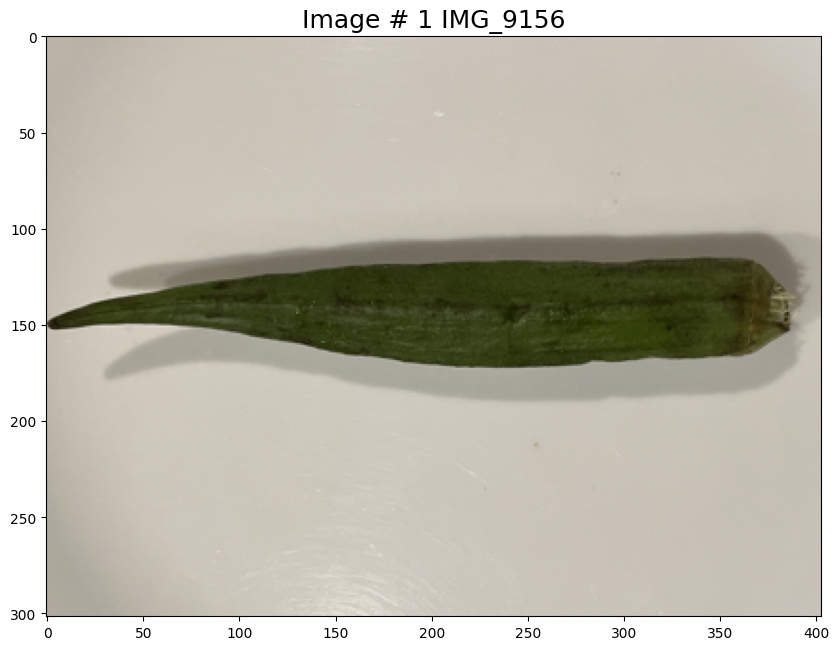

In [23]:
img_tensor = image.squeeze(0)
img_nparray = img_tensor.permute(1, 2, 0).numpy()

plt.figure(figsize=(10,10))
img_name = dataset.ids[iter_cnt - 1]
plt.title(f"Image # {iter_cnt} {img_name}", fontsize=18)
plt.imshow(img_nparray)

In [24]:
model.eval()
mask_pred = model(image)



# true_mask = torch.flip(vert_flipped_mask, dims=[1])
# neg_mask = ~true_mask

OrderedDict([('out', tensor([[[[-6.8401, -6.8401, -6.8401,  ..., -7.3895, -7.3895, -7.3895],
          [-6.8401, -6.8401, -6.8401,  ..., -7.3895, -7.3895, -7.3895],
          [-6.8401, -6.8401, -6.8401,  ..., -7.3895, -7.3895, -7.3895],
          ...,
          [-6.2007, -6.2007, -6.2007,  ..., -7.7151, -7.7151, -7.7151],
          [-6.2007, -6.2007, -6.2007,  ..., -7.7151, -7.7151, -7.7151],
          [-6.2007, -6.2007, -6.2007,  ..., -7.7151, -7.7151, -7.7151]]]],
       grad_fn=<UpsampleBilinear2DBackward0>))])


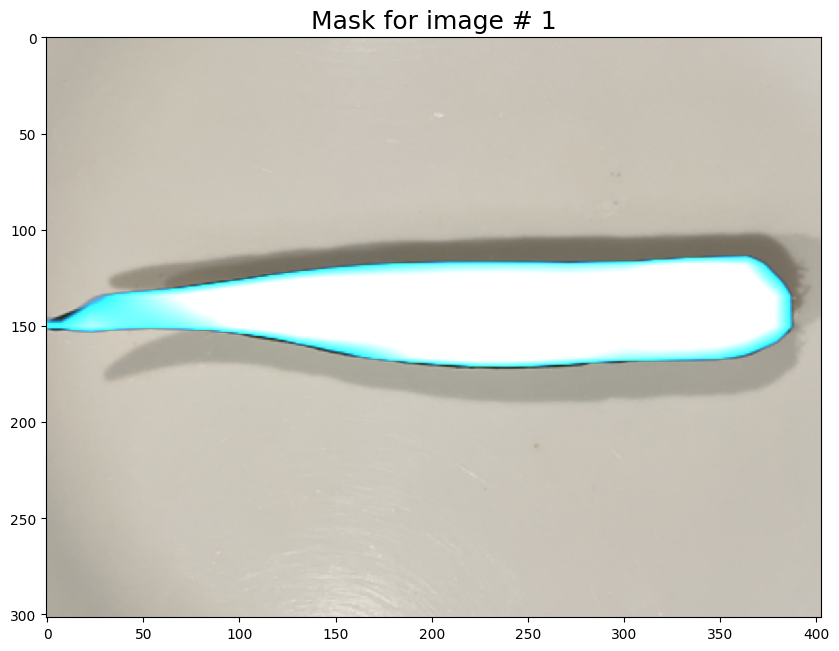

In [26]:
def show_image_with_mask(image, mask, iter_cnt):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask( mask, plt.gca())
    plt.title(f"Mask for image # {iter_cnt}", fontsize=18)
    # plt.axis('off')
    plt.show()

print(mask_pred)
show_image_with_mask(img_nparray, mask_pred['out'].detach(), iter_cnt)

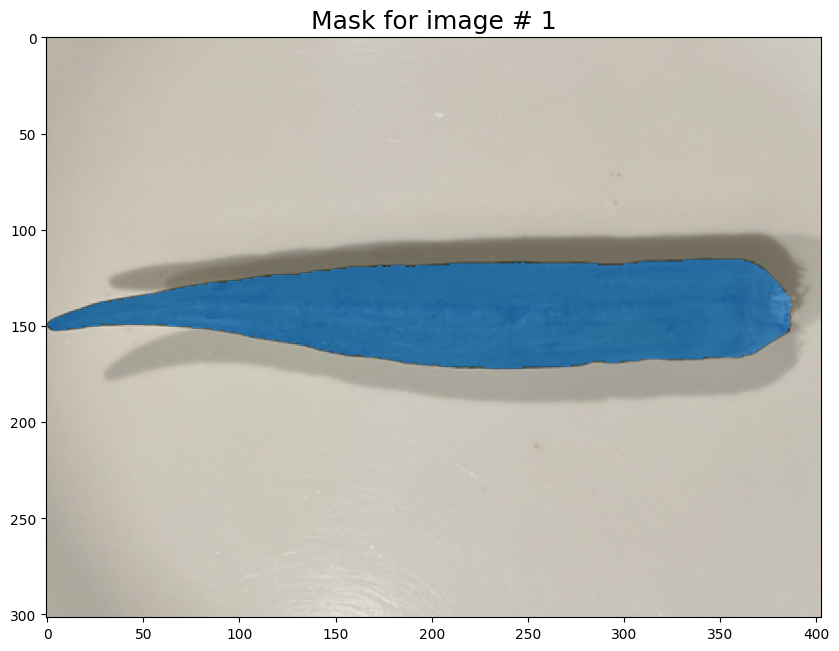

In [27]:
show_image_with_mask(img_nparray, target, iter_cnt)

In [ ]:
#x1 = torch.rand(4,).float()
#y1 = torch.randint(0,2, (4,)).float()
x1 = torch.randn(3, 1, 4, 4, requires_grad=True).float()
y1 = (torch.rand(3, 4, 4) > 0.5).float()
y1 = y1.unsqueeze(1)
print("x1 : ",x1.dtype, x1.shape)
print("y1 : ",y1.dtype, y1.shape)
print("x1 = ", x1)

# Directly calling nn.BCEWithLogitsLoss throws error
# l = nn.BCEWithLogitsLoss(x1, y1)
# RuntimeError: Boolean value of Tensor with more than one value is ambiguous
# so call thru functor

loss_fn1 = nn.BCEWithLogitsLoss()
loss_fn2 = nn.MSELoss()
l1 = loss_fn1(x1, y1)
l2 = loss_fn2(x1, y1)
print(l1)
print(l2)


x1 :  torch.float32 torch.Size([3, 1, 4, 4])
y1 :  torch.float32 torch.Size([3, 1, 4, 4])
x1 =  tensor([[[[ 0.6142,  0.6082,  0.3920, -0.5436],
          [-0.4809,  1.0770, -1.0921, -0.7398],
          [ 1.0926, -1.2116,  0.1297, -1.4881],
          [ 0.0507,  0.4029,  0.7711,  1.5993]]],


        [[[-0.3707, -0.3030,  1.2893, -1.4989],
          [ 0.1805,  0.9125, -0.0664, -0.5133],
          [ 1.0514,  0.0910, -0.8968,  0.6882],
          [ 0.5312, -0.6457, -1.2694,  0.3856]]],


        [[[ 0.9158,  1.6254, -0.1298,  0.8346],
          [ 0.3507, -0.4914,  0.3189, -0.7993],
          [ 0.5879,  1.6534,  0.4615,  0.0746],
          [ 1.7241,  1.0173,  0.0520,  0.2988]]]], requires_grad=True)
tensor(0.7616, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(1.0497, grad_fn=<MseLossBackward0>)


In [ ]:
# Generate random tensors
x = torch.randn(3, 1, 4, 4).float()
y = (torch.rand(3, 4, 4) > 0.5).float()

# Reshape y to have the same shape as x
y = y.unsqueeze(1)

# Define the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Compute the loss
loss = loss_fn(x, y)

print(loss)

tensor(0.8836)
